<a href="https://www.kaggle.com/code/mustafakapici/online-food-feedback?scriptVersionId=182916892" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Hello buddy, Comments are Welcomed, if you have suggestions & questions ? Please add them in discussion section, happy to have conversion with you, Cheers!

![thanks](https://i.imgflip.com/8ngeel.jpg)

# Import data and package stuff (☞ﾟヮﾟ)☞

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna, warnings, random
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

plt.style.use('dark_background')
warnings.simplefilter('ignore', category=FutureWarning)

In [2]:
path='/kaggle/input/online-food-dataset/onlinefoods.csv'

df = pd.read_csv(path)

df

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Output,Feedback,Unnamed: 12
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,Yes,Positive,Yes
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,Yes,Positive,Yes
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,Yes,Negative,Yes
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,Yes,Positive,Yes
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,Yes,Positive,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,23,Female,Single,Student,No Income,Post Graduate,2,12.9766,77.5993,560001,Yes,Positive,Yes
384,23,Female,Single,Student,No Income,Post Graduate,4,12.9854,77.7081,560048,Yes,Positive,Yes
385,22,Female,Single,Student,No Income,Post Graduate,5,12.9850,77.5533,560010,Yes,Positive,Yes
386,23,Male,Single,Student,Below Rs.10000,Post Graduate,2,12.9770,77.5773,560009,Yes,Positive,Yes


In [3]:
#drop unnecessary columns
df.drop(columns=['Unnamed: 12'], inplace=True)

# Data Insights 🧐

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         388 non-null    int64  
 1   Gender                      388 non-null    object 
 2   Marital Status              388 non-null    object 
 3   Occupation                  388 non-null    object 
 4   Monthly Income              388 non-null    object 
 5   Educational Qualifications  388 non-null    object 
 6   Family size                 388 non-null    int64  
 7   latitude                    388 non-null    float64
 8   longitude                   388 non-null    float64
 9   Pin code                    388 non-null    int64  
 10  Output                      388 non-null    object 
 11  Feedback                    388 non-null    object 
dtypes: float64(2), int64(3), object(7)
memory usage: 36.5+ KB


In [5]:
pd.DataFrame(df.isna().sum()).T.style.background_gradient(cmap='rainbow')

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Output,Feedback
0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
df.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'inferno')

,count,mean,std,min,0%,25%,30%,50%,75%,80%,100%,max
Age,388.000000,24.628866,2.975593,18.000000,18.000000,23.000000,23.000000,24.000000,26.000000,27.000000,33.000000,33.000000
Family size,388.000000,3.280928,1.351025,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000,5.000000,6.000000,6.000000
latitude,388.000000,12.972058,0.044489,12.865200,12.865200,12.936900,12.951720,12.977000,12.997025,13.006700,13.102000,13.102000
longitude,388.000000,77.600160,0.051354,77.484200,77.484200,77.565275,77.574100,77.592100,77.630900,77.640800,77.758200,77.758200
Pin code,388.000000,560040.113402,31.399609,560001.000000,560001.000000,560010.750000,560015.000000,560033.500000,560068.000000,560076.000000,560109.000000,560109.000000


In [7]:
target = 'Feedback'

cont_cols = df.select_dtypes('number').columns
cont_cols = cont_cols[cont_cols != target]

obj_cols = df.select_dtypes(object).columns
obj_cols = obj_cols[obj_cols != target]

#other_categorics = ['feature1','feature2','feature3','feature4','feature5']

obj_cols = obj_cols.tolist() 


# Convert cont_cols to a list and remove any columns that are in obj_cols
cont_cols = cont_cols.tolist()
cont_cols = [col for col in cont_cols if col not in obj_cols]

len(cont_cols), len(obj_cols)
print(f'Object cols: {obj_cols}')
print(f'Continuous Cols: {cont_cols}')

Object cols: ['Gender', 'Marital Status', 'Occupation', 'Monthly Income', 'Educational Qualifications', 'Output']
Continuous Cols: ['Age', 'Family size', 'latitude', 'longitude', 'Pin code']


In [8]:
def mPlotter(r, c, size, _targets, text):
    
    bg = '#010108'
    
    palette = ['#df5337', '#d24644', '#f7d340', '#3339FF', '#440a68', '#84206b', '#f1ef75', '#fbbe23', '#400a67']
    
    font = 'Comic Sans MS'
    
    fig = plt.figure(figsize=size)
    
    fig.patch.set_facecolor(bg)
    
    grid = fig.add_gridspec(r, c)
    
    grid.update(wspace=0.5, hspace=0.25)
    
    __empty_diff = ((r * c) - 1) - len(_targets)
        
    axes = []
    
    for i in range(r):
        for j in range(c):
            axes.append(fig.add_subplot(grid[i, j]))
    
    for idx, ax in enumerate(axes):
        ax.set_facecolor(bg) 
        
        if idx == 0:
            ax.spines["bottom"].set_visible(False)
            ax.tick_params(left=False, bottom=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.text(0.5, 0.5,
                 f'{text}',
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=18, 
                 fontweight='bold',
                 fontfamily=font,
                 color="#fff")
        else:
            if (idx - 1) < len(_targets):
                ax.set_title(_targets[idx - 1].capitalize(), fontsize=14, fontweight='bold', fontfamily=font, color="#fff")
                ax.grid(color='#fff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
                ax.set_xlabel("")
                ax.set_ylabel("")
            else:
                ax.spines["bottom"].set_visible(False)
                ax.tick_params(left=False, bottom=False)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
    def cb(ax):
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    if __empty_diff > 0:
        axes = axes[:-1*__empty_diff]
        
    return axes, palette, cb

# Data Visualization 📊

![eda](https://i.imgflip.com/8o7sml.jpg)

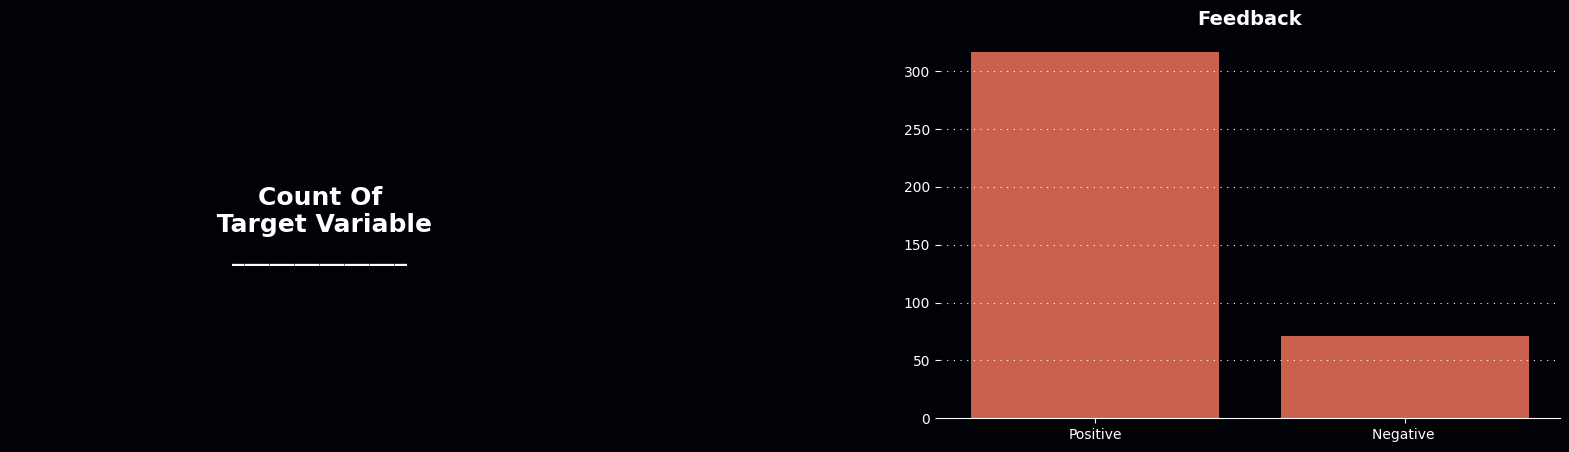

In [9]:
axes, palette, cb = mPlotter(1, 2, (20, 5), [target], 'Count Of\n Target Variable\n______________')

sns.countplot(x=df[target], ax = axes[1], color=palette[0])
cb(axes[1])

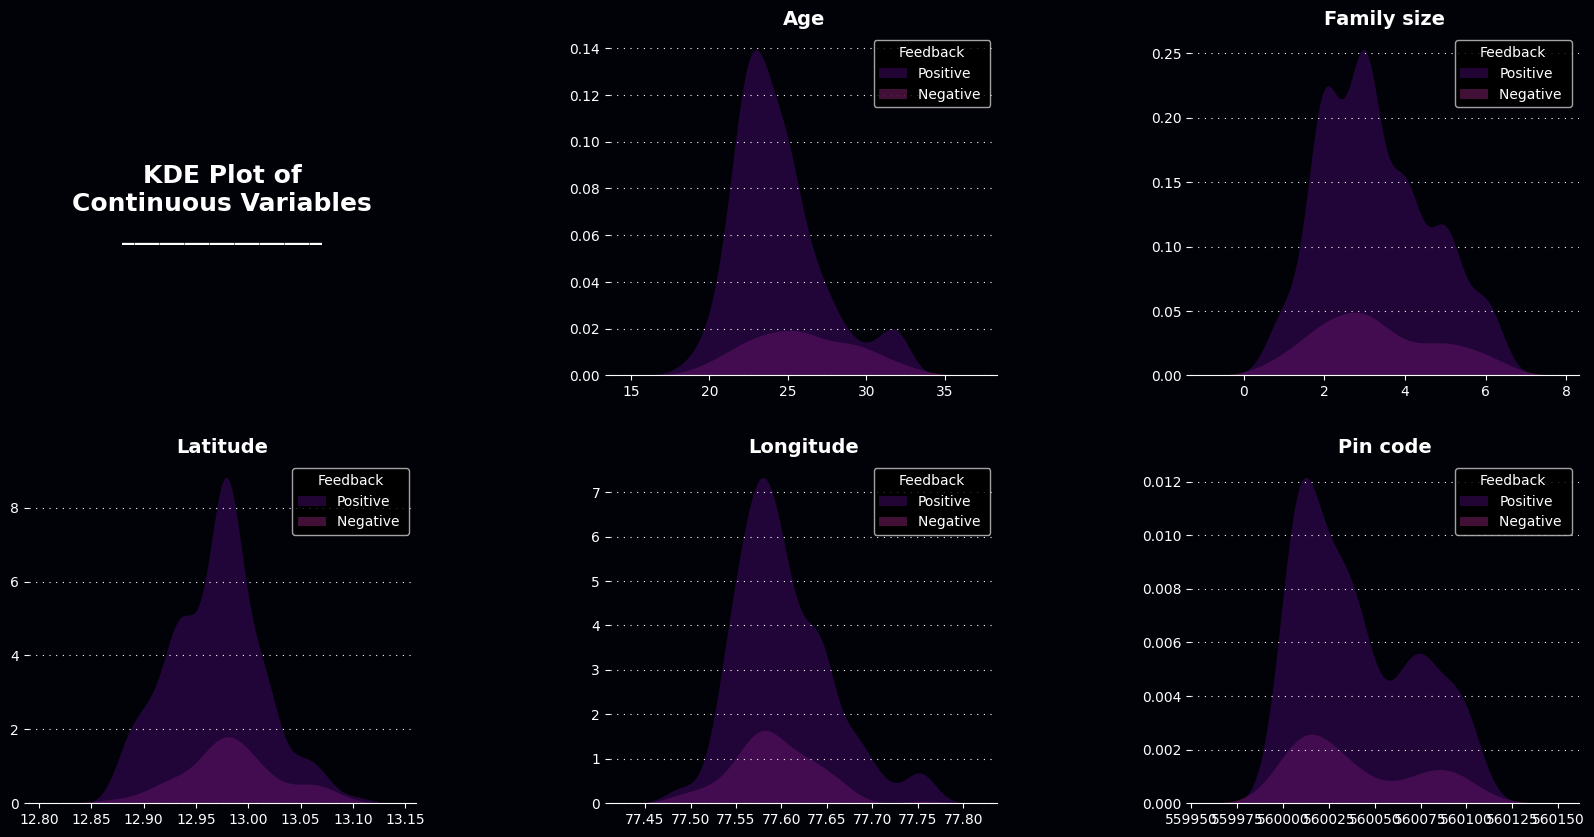

In [10]:
axes, palette, cb = mPlotter(2, 3, (20, 10), cont_cols, 'KDE Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[4:6], alpha=.5, linewidth=0, fill=True)
    cb(ax)

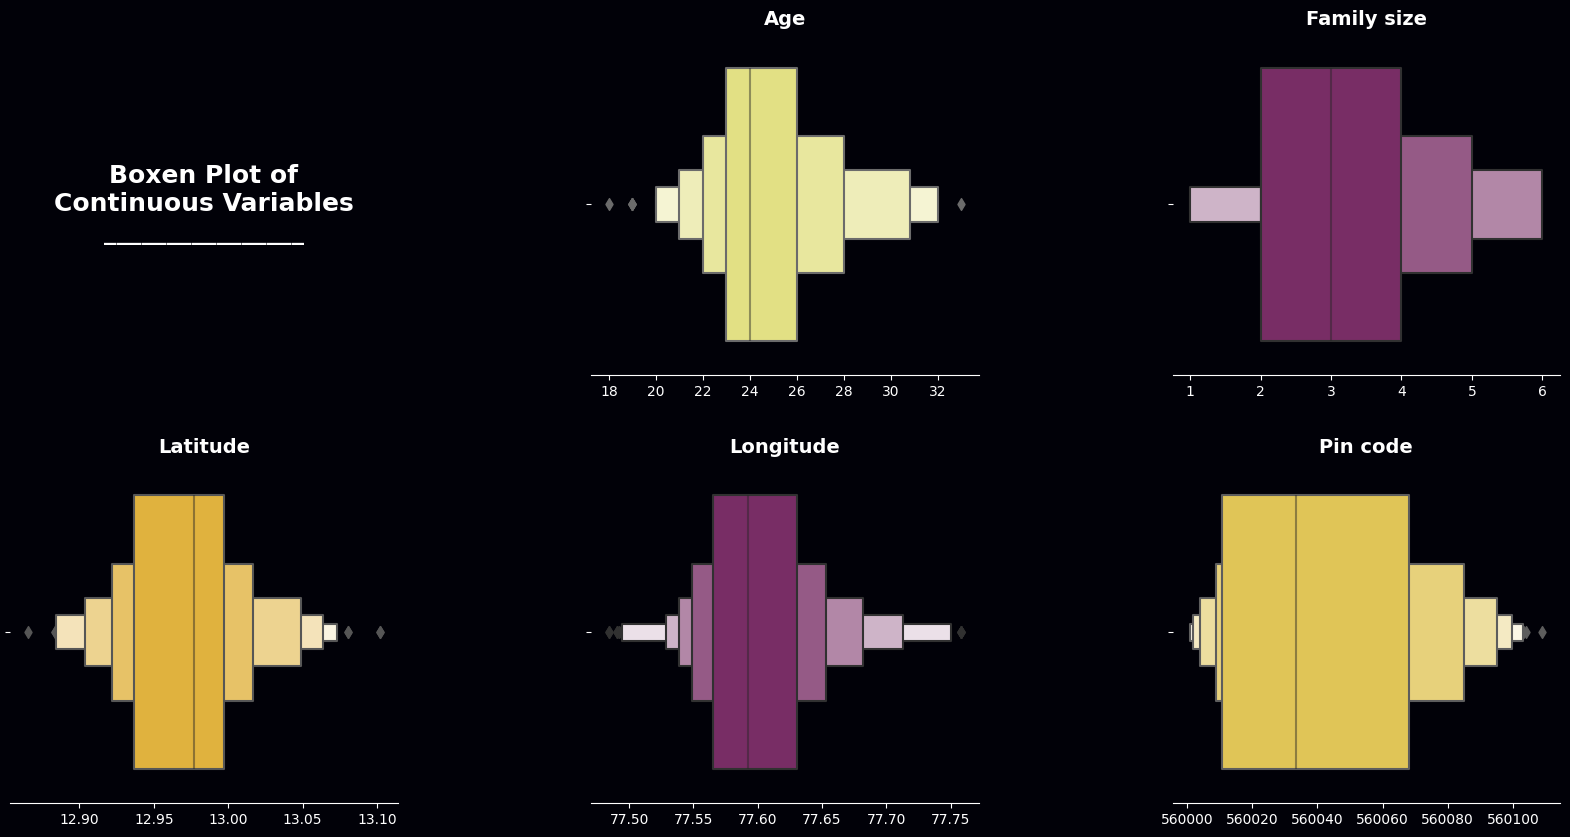

In [11]:
axes, palette, cb = mPlotter(2, 3, (20, 10), cont_cols, 'Boxen Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.boxenplot(data=df, x=col, ax=ax, palette=[palette[random.randint(0, len(palette)-1)]])
    cb(ax)

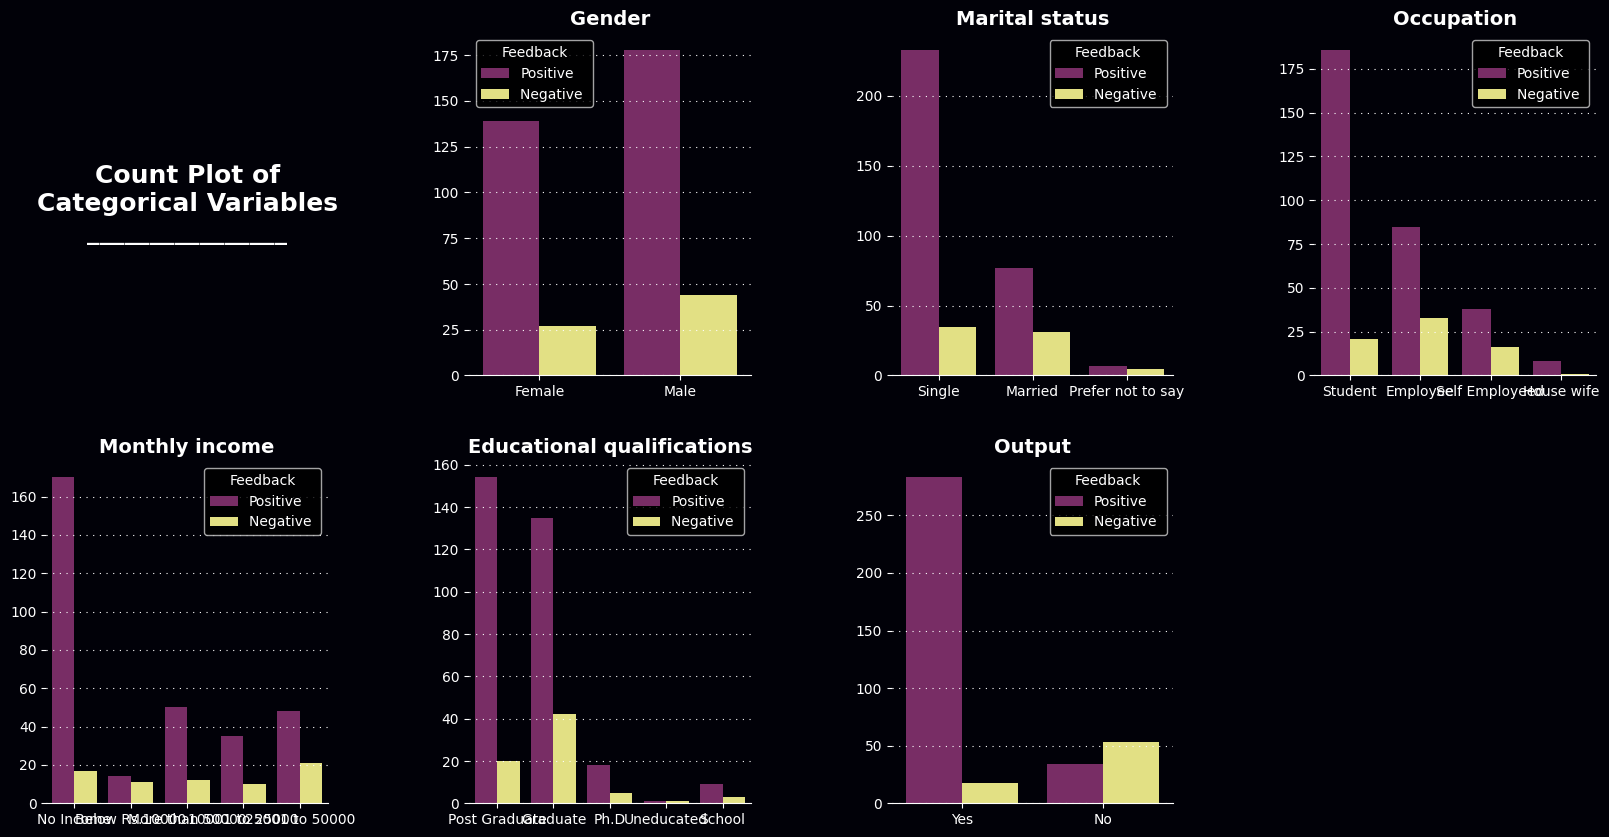

In [12]:
axes, palette, cb = mPlotter(2, 4, (20, 10), obj_cols, 'Count Plot of\nCategorical Variables\n________________')

for col, ax in zip(obj_cols, axes[1:]):
    sns.countplot(data=df, x=col, ax=ax, hue=target, palette=palette[5:7])
    cb(ax)

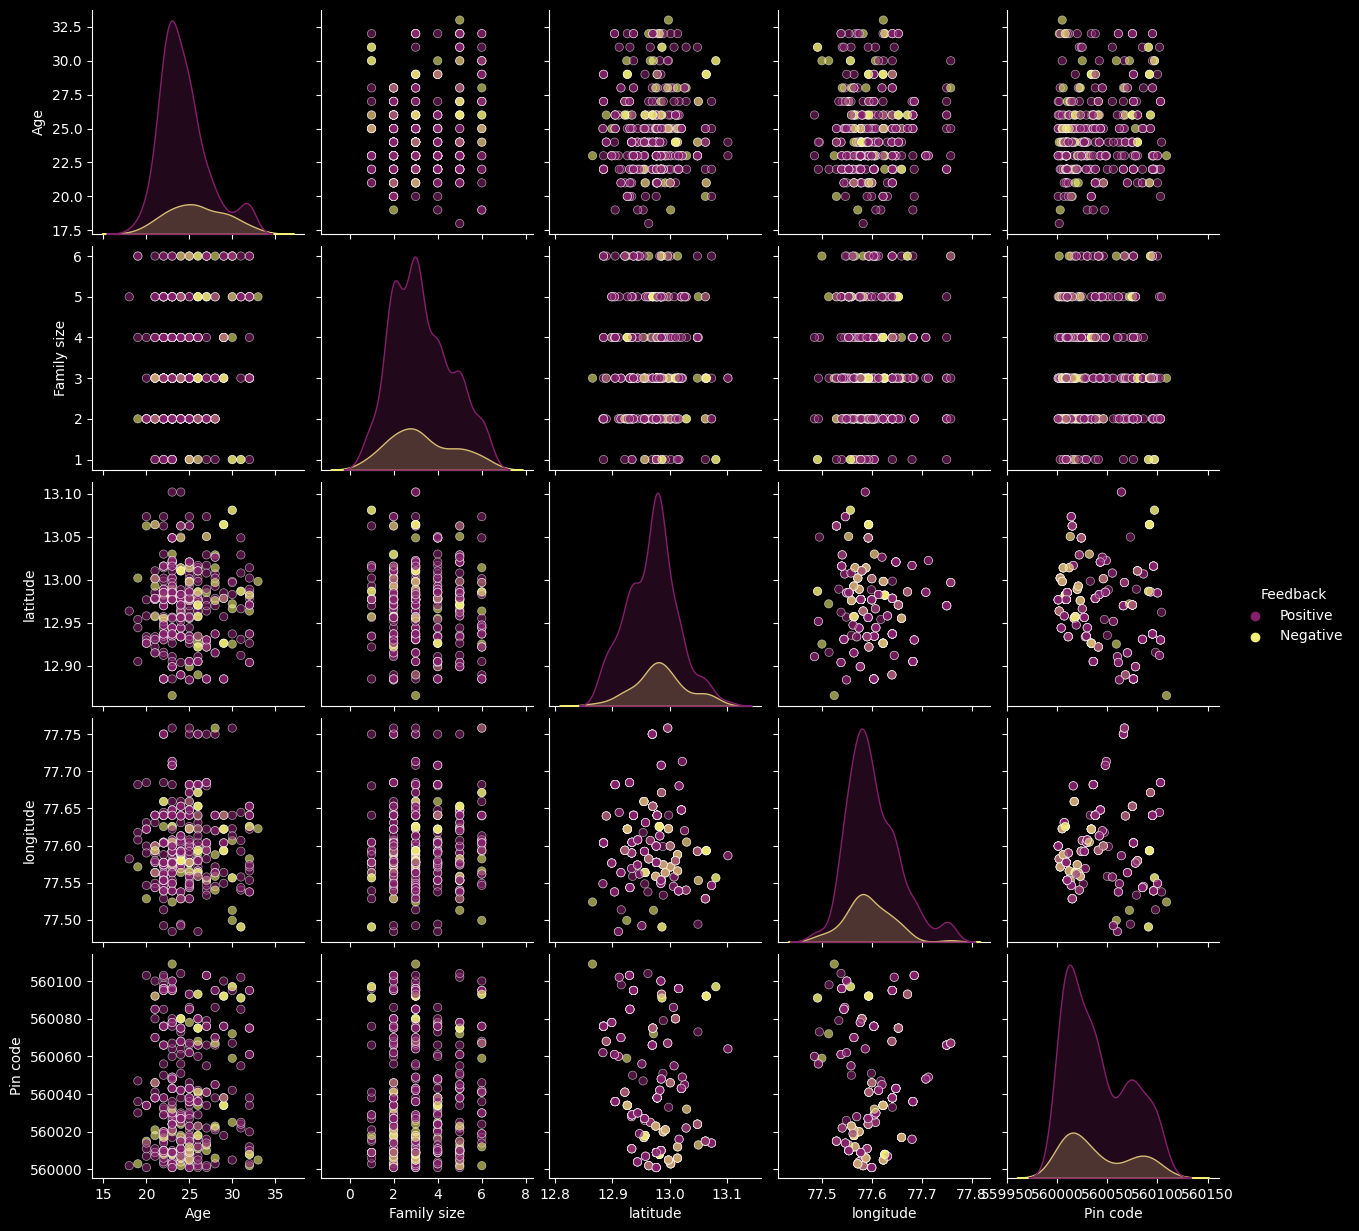

In [13]:
sns.pairplot(data=df, hue=target, palette=palette[5:7], diag_kind='kde', plot_kws={'alpha':.6})

In [14]:
ax = px.scatter_3d(df, x="Age", y="Family size", z="Pin code", template= "plotly_dark", color=target, title="3D Scatter Plot of Continuous Variables")

ax.show()

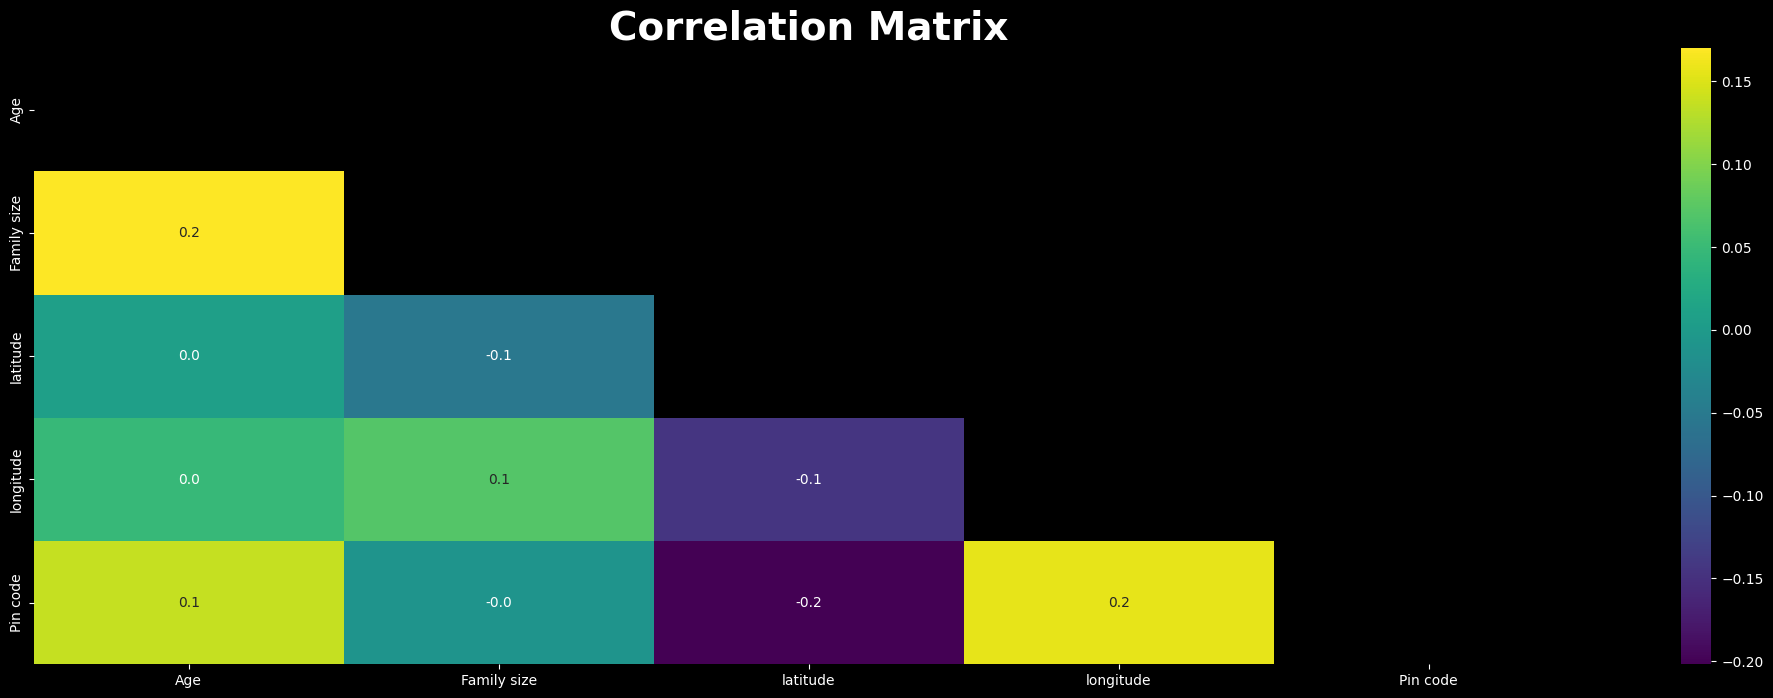

In [15]:
fig = plt.figure(figsize=(25, 8))

gs = fig.add_gridspec(1, 1)

gs.update(wspace=0.3, hspace=0.15)

ax = fig.add_subplot(gs[0, 0])

ax.set_title("Correlation Matrix", fontsize=28, fontweight='bold', fontfamily='Comic Sans MS', color="#fff")

sns.heatmap(df[cont_cols].corr().transpose(), mask=np.triu(np.ones_like(df[cont_cols].corr().transpose())), fmt=".1f", annot=True, cmap='viridis')

plt.show()

In [16]:
for col in df.select_dtypes(object):
    df[col] = LabelEncoder().fit_transform(df[col])
    
df

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Output,Feedback
0,20,0,2,3,4,2,4,12.9766,77.5993,560001,1,1
1,24,0,2,3,2,0,3,12.9770,77.5773,560009,1,1
2,22,1,2,3,2,2,3,12.9551,77.6593,560017,1,0
3,22,0,2,3,4,0,6,12.9473,77.5616,560019,1,1
4,22,1,2,3,2,2,4,12.9850,77.5533,560010,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
383,23,0,2,3,4,2,2,12.9766,77.5993,560001,1,1
384,23,0,2,3,4,2,4,12.9854,77.7081,560048,1,1
385,22,0,2,3,4,2,5,12.9850,77.5533,560010,1,1
386,23,1,2,3,2,2,2,12.9770,77.5773,560009,1,1


# Split the cakes equal 🍰

In [17]:
le = LabelEncoder()
df[target] = le.fit_transform(df[target])


In [18]:
X = df.drop(columns=[target], axis=1)
y = df[target].values

In [19]:
X.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Output
0,20,0,2,3,4,2,4,12.9766,77.5993,560001,1
1,24,0,2,3,2,0,3,12.9770,77.5773,560009,1
2,22,1,2,3,2,2,3,12.9551,77.6593,560017,1
3,22,0,2,3,4,0,6,12.9473,77.5616,560019,1
4,22,1,2,3,2,2,4,12.9850,77.5533,560010,1


In [20]:
y

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((271, 11), (117, 11), (271,), (117,))

# Scale the data to ground 🌄

In [22]:
X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

# The Black Magic 🧿

![model](https://i.imgflip.com/8o7ssy.jpg)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    #'XGBoost': XGBClassifier(),
    #'CatBoost': CatBoostClassifier(verbose=0),
    'KNN': KNeighborsClassifier(),
    #'Neural Network': MLPClassifier(),
    #'LGBM': LGBMClassifier(),
    'Voting Classifier': VotingClassifier(
        estimators=[
            ('cat', CatBoostClassifier(verbose=0)), 
            ('xg', XGBClassifier()), 
            ('lgbm', LGBMClassifier(verbose=-1))],
    voting='soft',
    verbose=False
)
}


params={
    'Logistic Regression': {'C': [0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [200]},
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'Random Forest': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'KNN': {'n_neighbors': [3, 5, 7, 9 , 13], 'weights': ['uniform', 'distance']},
    'Naive Bayes': { 'var_smoothing': [1e-9, 1e-8, 1e-7]},
    'Neural Network': {'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)], 
                       'activation': ['logistic', 'tanh', 'relu'],
                       'solver': ['adam'], 'alpha': [0.0001, 0.001, 0.01],
                       'max_iter': [ 500, 1000,2000]},
    'XGBoost': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'LGBM': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'CatBoost': {'iterations': [100, 300, 500], 'depth': [3, 5, 7, 9, 11, 13]},
    'Voting Classifier': {}
}

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score , f1_score ,classification_report

# Train function
def train_model(X_train, y_train, models, params):
    best_estimators = {}
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=params[model_name],
            scoring='accuracy',
            cv=5, n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        best_estimators[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best score for {model_name}: {grid_search.best_score_}\n")
    return best_estimators

# Evaluate function
def evaluate_model(X_test, y_test, models):
    classification_reports = {}

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

       

        classification_rep = classification_report(y_test, y_pred)

       

        classification_reports[model_name] = classification_rep

    return  classification_reports

In [25]:
# Train the models
best_models = train_model(X_train, y_train, models, params)

Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 1, 'max_iter': 200, 'solver': 'liblinear'}
Best score for Logistic Regression: 0.8447811447811449

Training Decision Tree...
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 11}
Best score for Decision Tree: 0.8966329966329966

Training Random Forest...
Best parameters for Random Forest: {'max_depth': 13, 'n_estimators': 300}
Best score for Random Forest: 0.889090909090909

Training Naive Bayes...
Best parameters for Naive Bayes: {'var_smoothing': 1e-09}
Best score for Naive Bayes: 0.8632323232323232

Training KNN...
Best parameters for KNN: {'n_neighbors': 3, 'weights': 'distance'}
Best score for KNN: 0.9038383838383839

Training Voting Classifier...
Best parameters for Voting Classifier: {}
Best score for Voting Classifier: 0.8817508417508417



In [26]:
# Evaluate the best models
classification_reports = evaluate_model(X_test, y_test, best_models)

Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Naive Bayes...
Evaluating KNN...
Evaluating Voting Classifier...


# Oversee the model performance 👀

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Print classification reports
for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.50      0.47      0.49        19
           1       0.90      0.91      0.90        98

    accuracy                           0.84       117
   macro avg       0.70      0.69      0.70       117
weighted avg       0.83      0.84      0.84       117


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.40      0.53      0.45        19
           1       0.90      0.85      0.87        98

    accuracy                           0.79       117
   macro avg       0.65      0.69      0.66       117
weighted avg       0.82      0.79      0.81       117


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.44      0.37      0.40        19
           1       0.88      0.91      0.89        98

    accuracy                           0.82       

![thanksagain](https://i.imgflip.com/8ou6ip.jpg)

![thanksagain](https://i.imgflip.com/8o7tp4.jpg)

#  Any suggestion to improve performance are welcomed.